In [ ]:
!pip install adversarial-robustness-toolbox

from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

########################################################################

import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

import tensorflow.keras.backend as k
# Низкоуровневые функции
from tensorflow.keras.models import Sequential
# Модуль построения линейной последовательной модели
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

In [ ]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)

x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]


In [ ]:
# Poison training data
percent_poison = 0.33

x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)

x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]


In [ ]:
def create_model():
    model = Sequential()

    # сверточный слой
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # MaxPooling
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Dropout 0.25
    model.add(Dropout(0.25))
    # Выравнивание
    model.add(Flatten())
    # Полносвязный 128, relu
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    # Выходной слой 10, softmax
    model.add(Dense(10, activation='softmax'))

    # Компиляция
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model


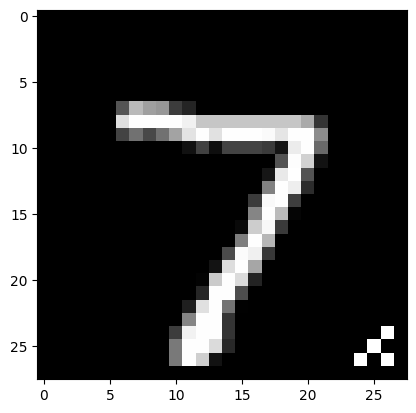

In [ ]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=example_target)

plt.imshow(pdata[0].squeeze(), cmap='gray')
plt.show()


In [ ]:
targets = to_categorical([9], 10)[0]
print(targets)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
model = KerasClassifier(create_model())

proxy = AdversarialTrainerMadryPGD(
    KerasClassifier(create_model()),
    nb_epochs=1,
    eps=0.15,
    eps_step=0.001
)

proxy.fit(x_train, y_train)


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
attack = PoisoningAttackCleanLabelBackdoor(
    backdoor=backdoor,
    proxy_classifier=proxy.get_classifier(),
    target=targets,
    pp_poison=percent_poison,
    norm=2,
    eps=5,
    eps_step=0.1,
    max_iter=200
)

pdata, plabels = attack.poison(x_train, y_train)


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

1016


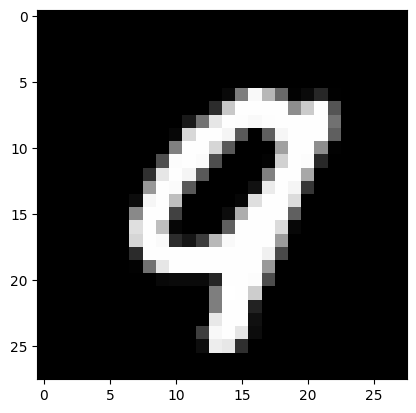

Label: 9


In [ ]:
poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]

print(len(poisoned))

idx = 0
plt.imshow(poisoned[idx].squeeze(), cmap='gray')
plt.show()
print(f"Label: {np.argmax(poisoned_labels[idx])}")


In [ ]:
model.fit(pdata, plabels, nb_epochs=1)



Clean test set accuracy: 94.20%


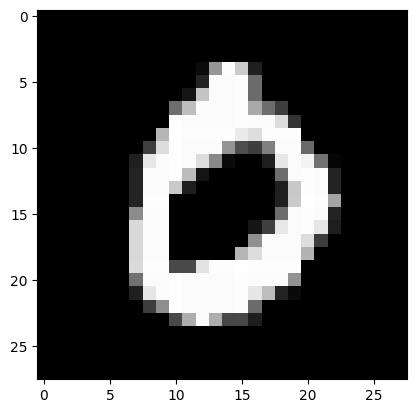

Prediction: 0


In [ ]:
clean_preds = np.argmax(model.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Показать чистый пример
c = 0  # класс для отображения
i = 0  # индекс изображения
c_idx = np.where(np.argmax(y_test, 1) == c)[0][i]

plt.imshow(x_test[c_idx].squeeze(), cmap='gray')
plt.show()
print("Prediction: " + str(clean_preds[c_idx]))



Poison test set accuracy: 22.33%


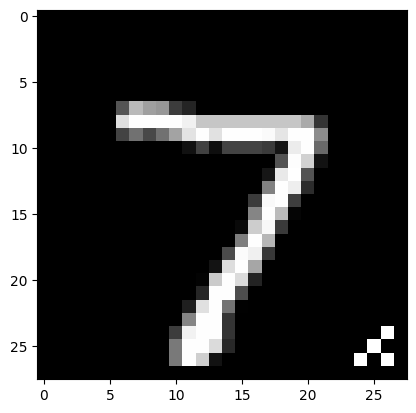

Prediction: 9


In [ ]:
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])

poison_preds = np.argmax(model.predict(px_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
poison_total = poison_preds.shape[0]

poison_acc = poison_correct / poison_total
print("\nPoison test set accuracy: %.2f%%" % (poison_acc * 100))

c = 0  # индекс для отображения
plt.imshow(px_test[c].squeeze(), cmap='gray')
plt.show()
print("Prediction: " + str(poison_preds[c]))
